Data ini terkait dengan kampanye pemasaran langsung (panggilan telepon) dari lembaga perbankan Portugis untuk menawarkan deposito berjangka ke orang-orang. Tujuan klasifikasi adalah untuk memprediksi apakah klien akan berlangganan deposito berjangka (target variable / variabel y)

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Mendownload dan menyiapkan dataset 
! kaggle datasets download prakharrathi25/banking-dataset-marketing-targets

banking-dataset-marketing-targets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Mengekstrak zip file
import zipfile

local_zip = '/content/banking-dataset-marketing-targets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
labelencoder = LabelEncoder()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [8]:
# Mengubah dataset menjadi dataframe

df = pd.read_csv('/content/train.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
df.shape

(45211, 17)

# **Checking Missing values & data types**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [11]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no any null values in this data. But, some columns have "unknown" category.
We replace the "unknown" values with "NaN" values, and then we fill the "NaN" values with the most common class in each column.
df_clean is the new name of the dataframe that has been cleaned.

In [12]:
df_clean = df.replace({'unknown' : np.nan})
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [13]:
df_clean = df_clean.apply(lambda x: x.fillna(x.value_counts().index[0]))
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,failure,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,failure,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,failure,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,failure,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,failure,no


# **Checking & Handling Outliers for numerical variables**

In [14]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**age**

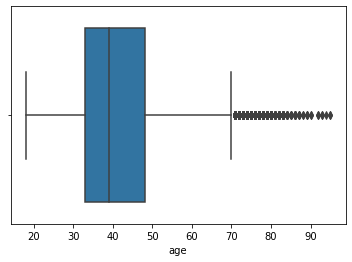

In [15]:
sns.boxplot(x=df['age'])

In [16]:
# variable age

Q1_age = df['age'].quantile(0.25)
Q3_age = df['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_bound_age = Q1_age - 1.5*IQR_age 
upper_bound_age = Q3_age + 1.5*IQR_age

outliers_age = df[df['age'] > upper_bound_age]
outliers_age.sort_values('age', ascending = False)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
41663,95,retired,married,secondary,no,0,no,no,telephone,1,oct,215,1,-1,0,unknown,no
33699,95,retired,divorced,primary,no,2282,no,no,telephone,21,apr,207,17,-1,0,unknown,yes
31233,94,retired,divorced,secondary,no,1234,no,no,cellular,3,mar,212,1,-1,0,unknown,no
44420,93,retired,married,unknown,no,775,no,no,cellular,4,aug,476,2,13,9,success,yes
44262,93,retired,married,unknown,no,775,no,no,cellular,22,jul,860,2,177,7,success,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30264,71,retired,married,tertiary,no,2651,no,no,cellular,5,feb,531,2,-1,0,unknown,no
43142,71,entrepreneur,married,tertiary,no,15265,no,no,cellular,25,feb,865,1,192,2,failure,no
42333,71,retired,married,secondary,no,5715,no,no,cellular,17,nov,747,2,-1,0,unknown,yes
41237,71,retired,divorced,secondary,no,5584,no,no,cellular,21,aug,534,3,-1,0,unknown,yes


**balance**

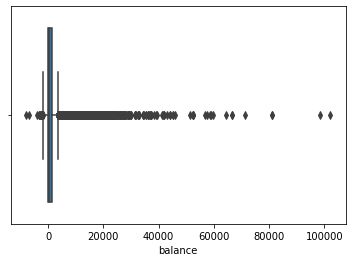

In [17]:
sns.boxplot(x=df['balance'])

In [18]:
# variable balance

df[df['balance'] < 0].sort_values('balance', ascending = True)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
12909,26,blue-collar,single,secondary,yes,-8019,no,yes,cellular,7,jul,299,3,-1,0,unknown,no
15682,49,management,married,tertiary,yes,-6847,no,yes,cellular,21,jul,206,1,-1,0,unknown,no
38736,60,management,divorced,tertiary,no,-4057,yes,no,cellular,18,may,242,6,-1,0,unknown,no
7413,43,management,married,tertiary,yes,-3372,yes,no,unknown,29,may,386,2,-1,0,unknown,no
1896,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36661,32,technician,single,secondary,no,-1,yes,no,cellular,12,may,37,1,-1,0,unknown,no
35440,37,management,divorced,tertiary,yes,-1,yes,yes,cellular,7,may,101,1,349,1,failure,no
21139,32,technician,married,secondary,no,-1,no,no,cellular,14,aug,153,6,-1,0,unknown,no
13430,34,housemaid,married,primary,no,-1,yes,no,cellular,9,jul,272,1,-1,0,unknown,no


*   from the box plot, we can see that there are 3766 rows in "balance" column that have value < 0.
*   on the other hand, "balance" column is the average yearly balance (in euros) that shouldn't be have negative values. 
*   after we see from the data intuitively, we can assume that there are human error in typing the balance data (when it should be positive value, but turns out negative)
*   therefore, we will change the balance that has negative value into positive values


In [19]:
df_clean[df_clean.columns[df_clean.dtypes != np.object]] = df_clean[df_clean.columns[df_clean.dtypes != np.object]].abs()
df_clean.balance.sort_values(ascending = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


22605         0
28309         0
10772         0
10754         0
28335         0
          ...  
41693     71188
43393     81204
42558     81204
26227     98417
39989    102127
Name: balance, Length: 45211, dtype: int64

**day**

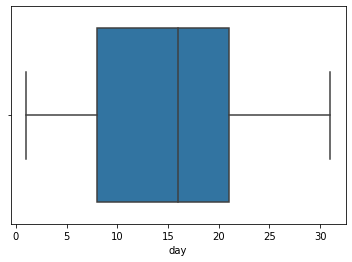

In [20]:
sns.boxplot(x=df['day'])

**duration**

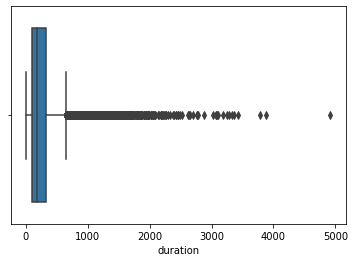

In [21]:
sns.boxplot(x=df['duration'])

In [22]:
# variable duration

Q1_duration = df['duration'].quantile(0.25)
Q3_duration = df['duration'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration
lower_bound_duration = Q1_duration - 1.5*IQR_duration
upper_bound_duration = Q3_duration + 1.5*IQR_duration

outliers_duration = df[df['duration'] > upper_bound_duration]
outliers_duration.sort_values('duration', ascending = False)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24148,59,technician,married,tertiary,no,6573,yes,no,telephone,10,nov,4918,1,-1,0,unknown,no
9947,59,management,married,secondary,no,1321,no,no,unknown,9,jun,3881,3,-1,0,unknown,yes
44602,45,services,single,secondary,no,955,no,no,unknown,27,aug,3785,1,-1,0,unknown,no
19639,37,blue-collar,married,tertiary,no,359,no,yes,cellular,7,aug,3422,2,-1,0,unknown,no
2386,45,blue-collar,married,secondary,no,66,yes,no,unknown,13,may,3366,3,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34797,43,blue-collar,married,secondary,no,388,yes,yes,cellular,6,may,644,1,355,2,failure,no
22127,56,technician,married,tertiary,no,73,no,no,cellular,21,aug,644,4,-1,0,unknown,yes
18743,43,services,married,secondary,no,642,no,no,cellular,31,jul,644,2,-1,0,unknown,no
18531,58,management,married,secondary,no,-382,no,no,cellular,31,jul,644,12,-1,0,unknown,yes


In [23]:
df_clean.drop(df_clean.index[df_clean['duration'] > 4000], inplace=True)
df_clean.sort_values('duration', ascending = False).head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
9947,59,management,married,secondary,no,1321,no,no,cellular,9,jun,3881,3,1,0,failure,yes
44602,45,services,single,secondary,no,955,no,no,cellular,27,aug,3785,1,1,0,failure,no
19639,37,blue-collar,married,tertiary,no,359,no,yes,cellular,7,aug,3422,2,1,0,failure,no
2386,45,blue-collar,married,secondary,no,66,yes,no,cellular,13,may,3366,3,1,0,failure,no
21113,43,self-employed,married,tertiary,no,423,no,no,cellular,14,aug,3322,2,1,0,failure,no
24095,30,admin.,married,secondary,no,1310,no,no,telephone,27,oct,3284,1,1,0,failure,no
24044,36,self-employed,single,tertiary,no,103,yes,yes,telephone,17,oct,3253,1,1,0,failure,yes
12347,28,admin.,single,secondary,no,7,no,yes,cellular,26,jun,3183,2,1,0,failure,yes
30747,53,admin.,married,secondary,no,849,yes,no,cellular,6,feb,3102,3,1,0,failure,yes
6451,44,services,divorced,secondary,no,51,yes,yes,cellular,27,may,3094,2,1,0,failure,yes


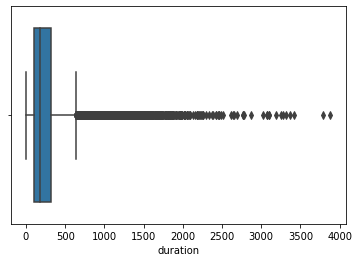

In [24]:
sns.boxplot(x = df_clean['duration'])

In [25]:
df_clean['duration(minutes)'] = (df_clean['duration'] / 60)
df_clean.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,duration(minutes)
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,1,0,failure,no,4.350000
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,1,0,failure,no,2.516667
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,1,0,failure,no,1.266667
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,1,0,failure,no,1.533333
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,1,0,failure,no,3.300000
5,35,management,married,tertiary,no,231,yes,no,cellular,5,may,139,1,1,0,failure,no,2.316667
6,28,management,single,tertiary,no,447,yes,yes,cellular,5,may,217,1,1,0,failure,no,3.616667
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,cellular,5,may,380,1,1,0,failure,no,6.333333
8,58,retired,married,primary,no,121,yes,no,cellular,5,may,50,1,1,0,failure,no,0.833333
9,43,technician,single,secondary,no,593,yes,no,cellular,5,may,55,1,1,0,failure,no,0.916667


**campaign**

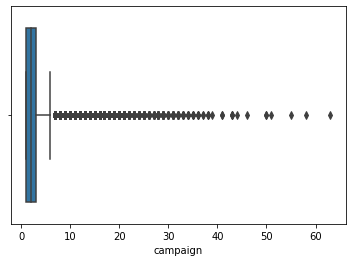

In [26]:
sns.boxplot(x=df['campaign'])

In [27]:
# variable campaign

Q1_campaign = df['campaign'].quantile(0.25)
Q3_campaign = df['campaign'].quantile(0.75)
IQR_campaign = Q3_campaign - Q1_campaign
lower_bound_campaign = Q1_campaign - 1.5*IQR_campaign
upper_bound_campaign = Q3_campaign + 1.5*IQR_campaign

outliers_campaign = df[df['campaign'] > upper_bound_campaign]
outliers_campaign.sort_values('campaign', ascending = False).head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4330,45,management,married,unknown,no,9051,yes,no,unknown,19,may,124,63,-1,0,unknown,no
11914,24,technician,single,primary,no,126,yes,no,unknown,20,jun,10,58,-1,0,unknown,no
5073,35,technician,married,secondary,no,432,yes,no,unknown,21,may,1094,55,-1,0,unknown,no
4299,30,management,single,tertiary,no,358,yes,no,unknown,19,may,88,51,-1,0,unknown,no
5459,35,blue-collar,married,secondary,no,430,yes,no,unknown,23,may,147,50,-1,0,unknown,no
18713,35,blue-collar,married,secondary,no,280,yes,yes,cellular,31,jul,65,50,-1,0,unknown,no
10697,28,blue-collar,single,secondary,no,235,yes,no,unknown,16,jun,102,46,-1,0,unknown,no
18744,49,blue-collar,married,primary,no,371,yes,no,cellular,31,jul,18,44,-1,0,unknown,no
4275,40,blue-collar,married,secondary,no,-365,yes,no,unknown,19,may,44,43,-1,0,unknown,no
13675,51,blue-collar,married,unknown,no,41,yes,no,telephone,9,jul,16,43,-1,0,unknown,no


**pdays**

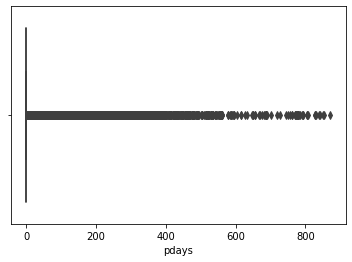

In [28]:
# for pdays

sns.boxplot(x=df['pdays'])

In [29]:
Q1_pdays = df['pdays'].quantile(0.25)
Q3_pdays = df['pdays'].quantile(0.75)
IQR_pdays = Q3_pdays - Q1_pdays
lower_bound_pdays = Q1_pdays - 1.5*IQR_pdays
upper_bound_pdays = Q3_pdays + 1.5*IQR_pdays

outliers_pdays = df[df['pdays'] > upper_bound_pdays]
outliers_pdays.sort_values('pdays', ascending = False)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45146,49,unemployed,divorced,tertiary,no,780,no,no,cellular,8,nov,148,1,871,2,failure,no
44829,37,management,divorced,tertiary,no,488,yes,no,cellular,17,sep,328,1,854,2,failure,yes
44837,35,management,single,tertiary,no,151,no,no,unknown,20,sep,11,1,850,2,failure,no
44858,31,housemaid,married,secondary,no,243,yes,no,cellular,23,sep,305,2,842,1,failure,yes
44785,43,blue-collar,married,secondary,no,408,yes,no,unknown,14,sep,6,1,838,3,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44403,68,retired,married,tertiary,no,2812,no,no,cellular,4,aug,651,1,1,7,success,yes
44428,34,admin.,married,tertiary,no,69,no,yes,cellular,4,aug,120,3,1,6,success,yes
44429,42,management,married,tertiary,no,372,yes,no,cellular,4,aug,153,3,1,2,success,yes
44402,29,management,married,tertiary,no,198,yes,no,cellular,4,aug,453,1,1,1,failure,no


**previous**

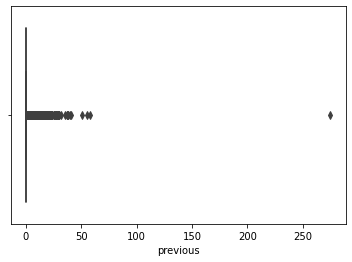

In [30]:
# for previous

sns.boxplot(x=df['previous'])

In [31]:
Q1_previous = df['previous'].quantile(0.25)
Q3_previous = df['previous'].quantile(0.75)
IQR_previous = Q3_previous - Q1_previous
lower_bound_previous = Q1_previous - 1.5*IQR_previous 
upper_bound_previous = Q3_previous + 1.5*IQR_previous

outliers_previous = df[df['previous'] > upper_bound_previous]
outliers_previous.sort_values('previous', ascending = False)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no
38326,46,blue-collar,married,primary,no,1085,yes,yes,cellular,15,may,523,2,353,58,other,yes
44089,37,technician,married,secondary,no,432,yes,no,cellular,6,jul,386,3,776,55,failure,yes
28886,31,management,single,tertiary,no,358,yes,no,cellular,30,jan,68,3,256,51,failure,no
44822,27,blue-collar,married,secondary,no,821,yes,yes,unknown,16,sep,23,1,778,41,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41682,54,management,married,tertiary,no,1464,no,no,cellular,2,oct,194,2,94,1,success,yes
41683,54,management,married,tertiary,no,8295,no,no,cellular,2,oct,849,2,119,1,success,yes
41687,26,management,single,tertiary,no,170,no,no,cellular,2,oct,160,2,109,1,success,no
37034,30,technician,single,secondary,no,115,no,no,cellular,13,may,152,1,351,1,failure,no


In [32]:
df_clean.drop(df_clean.index[df_clean['previous'] > 60], inplace=True)
df_clean.sort_values('previous', ascending = False).head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,duration(minutes)
38326,46,blue-collar,married,primary,no,1085,yes,yes,cellular,15,may,523,2,353,58,other,yes,8.716667
44089,37,technician,married,secondary,no,432,yes,no,cellular,6,jul,386,3,776,55,failure,yes,6.433333
28886,31,management,single,tertiary,no,358,yes,no,cellular,30,jan,68,3,256,51,failure,no,1.133333
44822,27,blue-collar,married,secondary,no,821,yes,yes,cellular,16,sep,23,1,778,41,other,no,0.383333
42611,35,technician,single,secondary,no,4645,yes,no,cellular,11,jan,502,3,270,40,other,no,8.366667
28498,49,management,single,tertiary,no,145,yes,no,cellular,29,jan,57,2,248,38,failure,no,0.950000
37567,39,management,married,tertiary,no,0,yes,no,cellular,14,may,11,15,261,38,failure,no,0.183333
26668,51,entrepreneur,married,secondary,no,653,yes,no,cellular,20,nov,16,9,112,37,other,no,0.266667
42422,27,student,single,secondary,no,91,no,no,telephone,4,dec,157,6,95,37,other,no,2.616667
44484,28,management,single,tertiary,no,6791,no,no,telephone,9,aug,361,1,46,35,failure,no,6.016667


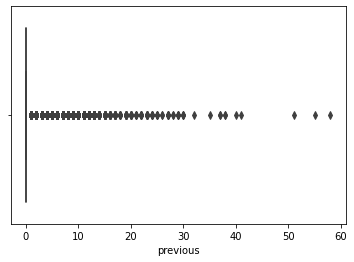

In [33]:
sns.boxplot(x=df_clean['previous'])

# **Age and Categorical Variables**

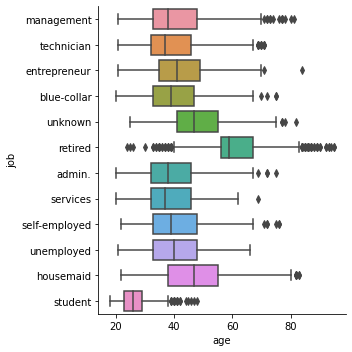

In [34]:
# age & job

sns.catplot(x="age", y="job", kind="box", dodge=False, data=df)

From the box plots, this makes no sense because there are 40 people with age under 40 years old who already retired. But, when we check the data, most of those people still have the house loan or any other loan, and have small balance. 

In [35]:
retired = df_clean[df_clean['job'] == 'retired']
retired_under_40 = retired[retired['age'] <= 40].sort_values('age', ascending = True)
retired_under_40.count()

age                  40
job                  40
marital              40
education            40
default              40
balance              40
housing              40
loan                 40
contact              40
day                  40
month                40
duration             40
campaign             40
pdays                40
previous             40
poutcome             40
y                    40
duration(minutes)    40
dtype: int64

Remove rows that have job = retired and age <= 40

In [36]:
df_clean = df_clean[~((df_clean.job == 'retired') & (df_clean.age <= 40))]

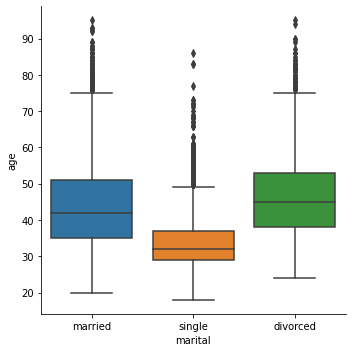

In [37]:
# age & marital

sns.catplot(x="marital", y="age", kind="box", dodge=False, data=df)

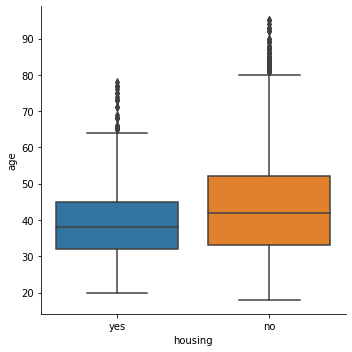

In [38]:
# age & housing

sns.catplot(x="housing", y="age", kind="box", dodge=False, data=df)

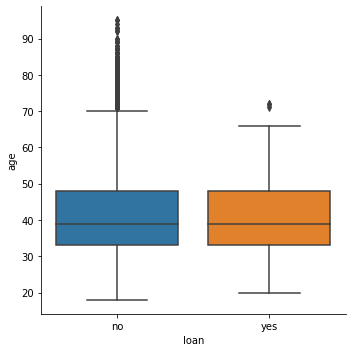

In [39]:
# age & loan

sns.catplot(x="loan", y="age", kind="box", dodge=False, data=df)

In [40]:
df_clean = df_clean[~((df_clean.loan == 'yes') & (df_clean.age > 70))]

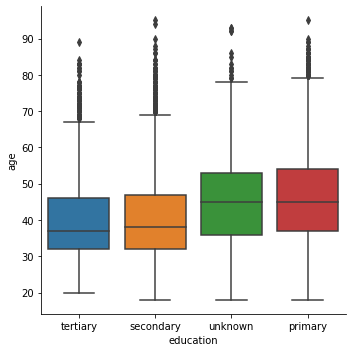

In [41]:
# age & education

sns.catplot(x="education", y="age", kind="box", dodge=False, data=df)

In [42]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [43]:
df_clean.describe()

,age,balance,day,duration,campaign,pdays,previous,duration(minutes)
count,45166.000000,45166.000000,45166.000000,45166.000000,45166.000000,45166.000000,45166.000000,45166.000000
mean,40.937475,1415.911371,15.808971,258.041071,2.764580,41.815281,0.574547,4.300685
std,10.619297,3021.729176,8.322350,256.561507,3.099115,99.424934,1.908655,4.276025
min,18.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,33.000000,137.000000,8.000000,103.000000,1.000000,1.000000,0.000000,1.716667
50%,39.000000,485.000000,16.000000,180.000000,2.000000,1.000000,0.000000,3.000000
75%,48.000000,1437.000000,21.000000,319.000000,3.000000,1.000000,0.000000,5.316667
max,95.000000,102127.000000,31.000000,3881.000000,63.000000,871.000000,58.000000,64.683333


# **EDA (raw data)**

**Distribution of Age**

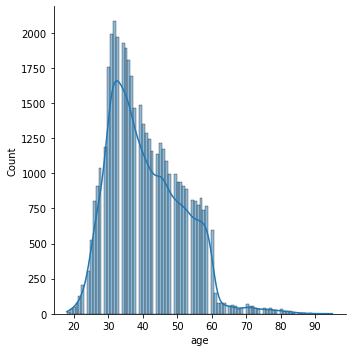

In [44]:
sns.displot(data = df, x = "age", kde = True)

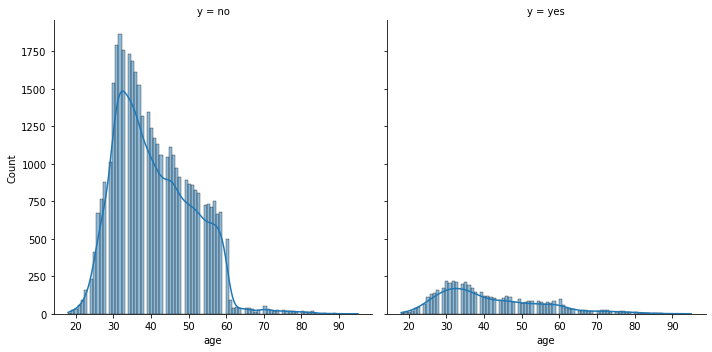

In [45]:
sns.displot(data = df, x = "age", col = "y", kde = True)

**Job & y**

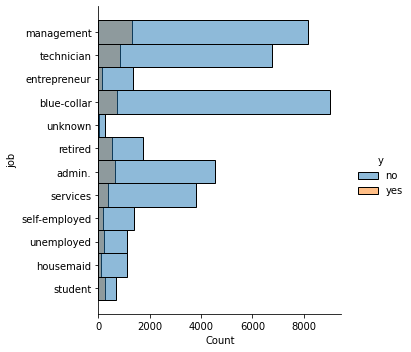

In [46]:
sns.displot(data=df, y="job", hue = "y")

**marital & y**

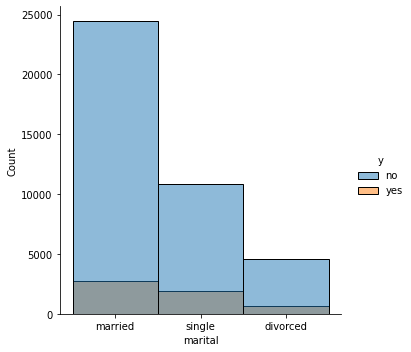

In [47]:
sns.displot(data=df, x="marital", hue = "y")

**education & y**

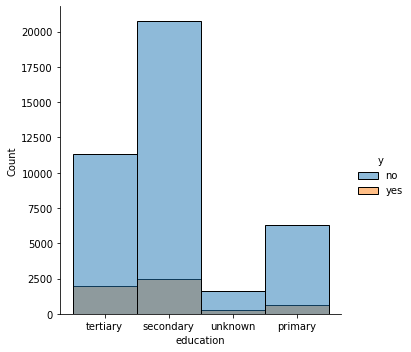

In [48]:
sns.displot(data=df, x="education", hue = "y")

**default & y**

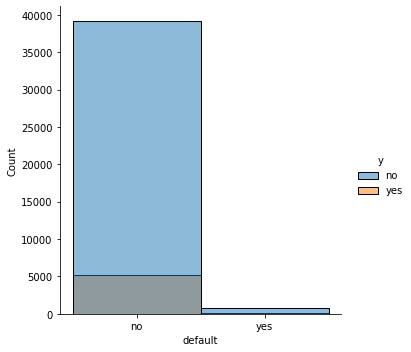

In [49]:
sns.displot(data=df, x="default", hue = "y")

**balance & y**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56ce23fc50>,
      dtype=object)

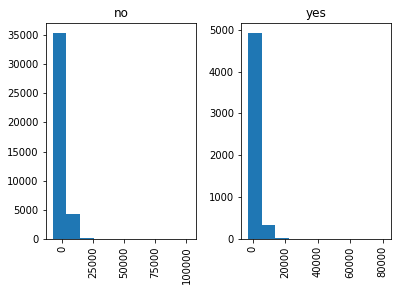

In [50]:
df.hist("balance", "y")

**housing & y**

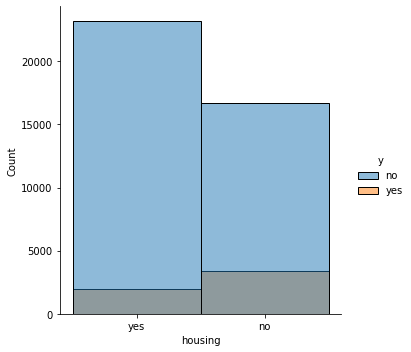

In [51]:
sns.displot(data=df, x="housing", hue = "y")

**loan & y**

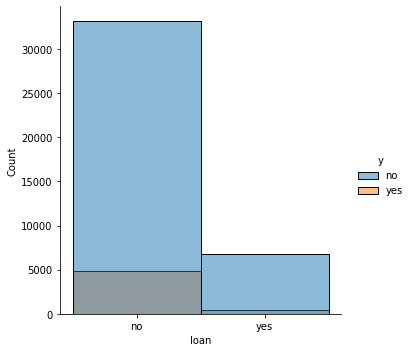

In [52]:
sns.displot(data=df, x="loan", hue = "y")

**contact & y**

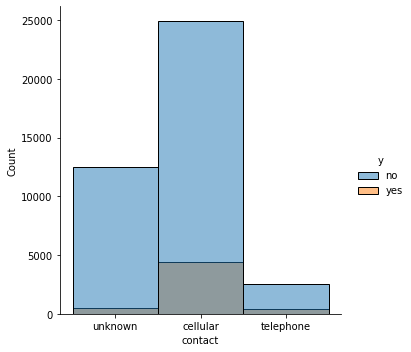

In [53]:
sns.displot(data=df, x="contact", hue = "y")

**day & y**

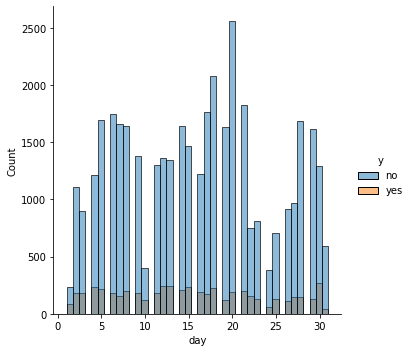

In [54]:
sns.displot(data=df, x="day", hue = "y")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56ce085b90>,
      dtype=object)

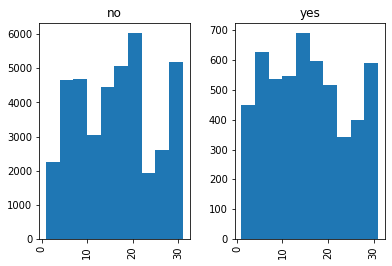

In [55]:
df.hist("day", "y")

**month & y**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56cddb08d0>,
      dtype=object)

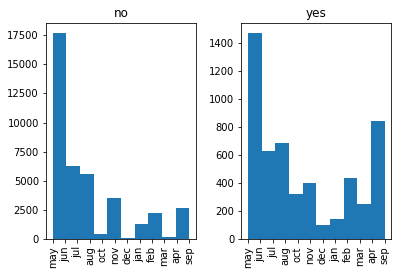

In [56]:
df.hist("month", "y")

**duration & y**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56cdc63a50>,
      dtype=object)

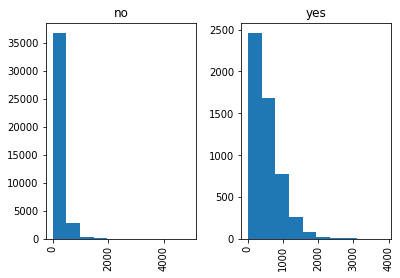

In [57]:
df.hist("duration", "y")

**campaign & y**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56cdd61550>,
      dtype=object)

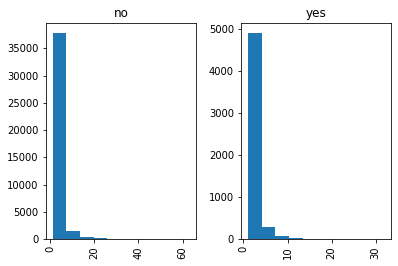

In [58]:
df.hist("campaign", "y")

**pdays & y**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56cda01950>,
      dtype=object)

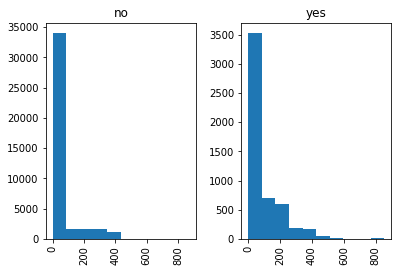

In [59]:
df.hist("pdays", "y")

**previous & y**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56cda48650>,
      dtype=object)

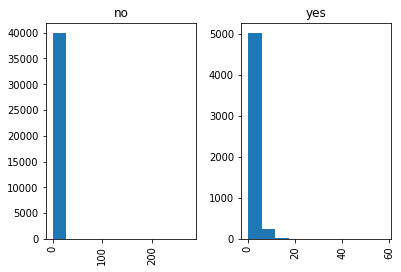

In [60]:
df.hist("previous", "y")

**poutcome & y**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56cd888790>,
      dtype=object)

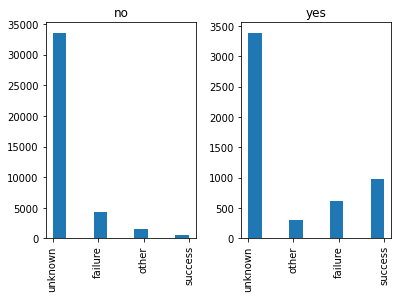

In [61]:
df.hist("poutcome", "y")

**y**

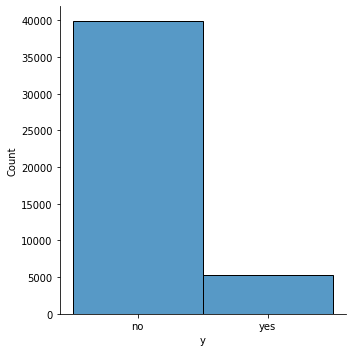

In [62]:
sns.displot(data = df, x = 'y')

# **CATEGORICAL DATA ENCODING**

**LABEL ENCODER**

In [63]:
df_encoded = df_clean.copy()
df_encoded.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,duration(minutes)
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,1,0,failure,no,4.350000
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,1,0,failure,no,2.516667
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,1,0,failure,no,1.266667
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,1,0,failure,no,1.533333
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,1,0,failure,no,3.300000


In [64]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45166 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45166 non-null  int64  
 1   job                45166 non-null  object 
 2   marital            45166 non-null  object 
 3   education          45166 non-null  object 
 4   default            45166 non-null  object 
 5   balance            45166 non-null  int64  
 6   housing            45166 non-null  object 
 7   loan               45166 non-null  object 
 8   contact            45166 non-null  object 
 9   day                45166 non-null  int64  
 10  month              45166 non-null  object 
 11  duration           45166 non-null  int64  
 12  campaign           45166 non-null  int64  
 13  pdays              45166 non-null  int64  
 14  previous           45166 non-null  int64  
 15  poutcome           45166 non-null  object 
 16  y                  451

In [65]:
df_encoded = pd.concat([
        df_encoded.select_dtypes([], ['object']),
        df_encoded.select_dtypes(['object']).apply(pd.Categorical, ordered=True)
        ], axis=1).reindex(df_encoded.columns, axis=1)

In [66]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45166 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                45166 non-null  int64   
 1   job                45166 non-null  category
 2   marital            45166 non-null  category
 3   education          45166 non-null  category
 4   default            45166 non-null  category
 5   balance            45166 non-null  int64   
 6   housing            45166 non-null  category
 7   loan               45166 non-null  category
 8   contact            45166 non-null  category
 9   day                45166 non-null  int64   
 10  month              45166 non-null  category
 11  duration           45166 non-null  int64   
 12  campaign           45166 non-null  int64   
 13  pdays              45166 non-null  int64   
 14  previous           45166 non-null  int64   
 15  poutcome           45166 non-null  category
 16  y   

In [67]:
df_encoded['job'] = df_encoded['job'].cat.codes
df_encoded['marital'] = df_encoded['marital'].cat.codes
df_encoded['education'] = df_encoded['education'].cat.codes
df_encoded['default'] = df_encoded['default'].cat.codes
df_encoded['housing'] = df_encoded['housing'].cat.codes
df_encoded['loan'] = df_encoded['loan'].cat.codes
df_encoded['contact'] = df_encoded['contact'].cat.codes
df_encoded['month'] = df_encoded['month'].cat.codes
df_encoded['poutcome'] = df_encoded['poutcome'].cat.codes
df_encoded['y'] = df_encoded['y'].cat.codes

In [68]:
df_encoded.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,duration(minutes)
0,58,4,1,2,0,2143,1,0,0,5,8,261,1,1,0,0,0,4.350000
1,44,9,2,1,0,29,1,0,0,5,8,151,1,1,0,0,0,2.516667
2,33,2,1,1,0,2,1,1,0,5,8,76,1,1,0,0,0,1.266667
3,47,1,1,1,0,1506,1,0,0,5,8,92,1,1,0,0,0,1.533333
4,33,1,2,1,0,1,0,0,0,5,8,198,1,1,0,0,0,3.300000


(INI encode nya sesuai urutan abjad yah, misalkan no 0 yes 1, blue collar 0 entrepreneur 1, dst)

**ONE HOT ENCODING**

# **TRAIN TEST SPLIT**

In [69]:
X = df_encoded.drop('y', axis=1).values

In [70]:
X

array([[58.        ,  4.        ,  1.        , ...,  0.        ,
         0.        ,  4.35      ],
       [44.        ,  9.        ,  2.        , ...,  0.        ,
         0.        ,  2.51666667],
       [33.        ,  2.        ,  1.        , ...,  0.        ,
         0.        ,  1.26666667],
       ...,
       [72.        ,  5.        ,  1.        , ...,  3.        ,
         2.        , 18.78333333],
       [57.        ,  1.        ,  1.        , ...,  0.        ,
         0.        ,  8.46666667],
       [37.        ,  2.        ,  1.        , ..., 11.        ,
         1.        ,  6.01666667]])

In [71]:
X.shape

(45166, 17)

In [72]:
y = df_encoded['y'].values

In [73]:
y

array([0, 0, 0, ..., 1, 0, 0], dtype=int8)

In [74]:
y.shape

(45166,)

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
# Model import
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [77]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

In [78]:
y_train.shape

(31616,)

## Evaluating Models

In [79]:
# common models
models = {'Logistic Regression':LogisticRegression(),
          'KNN':KNeighborsClassifier(),
          'SVM':SVC(),
          'SGD_log':SGDClassifier(loss='log', random_state=42),
          'SGD_svm':SGDClassifier(loss='hinge', random_state=42),
          'Decision Tree': DecisionTreeClassifier(random_state=42)}
results = []
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  cv_results = cross_val_score(model, X_train_scal, y_train, cv=kf)
  results.append(cv_results)

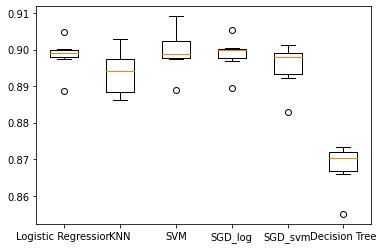

In [80]:
plt.boxplot(results, labels=models.keys())
plt.show()

In [81]:
for name, model in models.items():
  model.fit(X_train_scal, y_train)
  test_score = model.score(X_test_scal, y_test)
  print('{} acc = {}'.format(name, test_score))

Logistic Regression acc = 0.8993357933579336
KNN acc = 0.8942435424354244
SVM acc = 0.8980811808118081
SGD_log acc = 0.8950553505535055
SGD_svm acc = 0.8878228782287823
Decision Tree acc = 0.8669372693726938


In [82]:
steps = [('pca', PCA(n_components=2)),
         ('lr', LogisticRegression(random_state=42))]
pipeline = Pipeline(steps)
parameters = {
    'lr__penalty':['l1','l2'],
    'lr__C': np.linspace(0.1, 1.0, 10),
    'lr__tol':np.linspace(0.0001, 1.0, 10),
    "lr__class_weight": ["balanced", {0:0.8, 1:0.2}],
    'lr__solver': ['saga']
}
kf = KFold(n_splits=6, random_state=42, shuffle=True)
cv = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=kf)
cv.fit(X_train_scal, y_train)
print('best score = {}'.format(cv.best_score_))
print('best parameter= {}'.format(cv.best_params_))

best score = 0.8401781963592779
best parameter= {'lr__C': 0.8, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__solver': 'saga', 'lr__tol': 0.8889}


In [83]:
best_model = cv.best_estimator_
best_model.get_params()

{'lr': LogisticRegression(C=0.8, class_weight='balanced', penalty='l1',
                    random_state=42, solver='saga', tol=0.8889),
 'lr__C': 0.8,
 'lr__class_weight': 'balanced',
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l1',
 'lr__random_state': 42,
 'lr__solver': 'saga',
 'lr__tol': 0.8889,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'memory': None,
 'pca': PCA(n_components=2),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 2,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'steps': [('pca', PCA(n_components=2)),
  ('lr', LogisticRegression(C=0.8, class_weight='balanced', penalty='l1',
                      random_state=42, solver='saga', tol=0.8889))],
 'verbose': False}

In [84]:
y_pred = best_model.predict(X_test_scal)

In [85]:
print(confusion_matrix(y_test, y_pred))

[[9570 2394]
 [ 431 1155]]


In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87     11964
           1       0.33      0.73      0.45      1586

    accuracy                           0.79     13550
   macro avg       0.64      0.76      0.66     13550
weighted avg       0.88      0.79      0.82     13550



In [87]:
y_pred_prob = best_model.predict_proba(X_test_scal)[:,1]

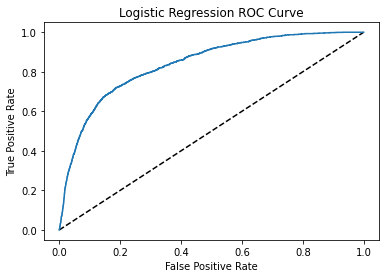

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [89]:
print(roc_auc_score(y_test, y_pred_prob))

0.8391325721595218
